The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.173% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

### Load the dataset 

In [2]:
# Read the csv file
data = pd.read_csv('creditcardfraud/creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

### Exploratory Data Analysis

#### Plot histogram of each attribute

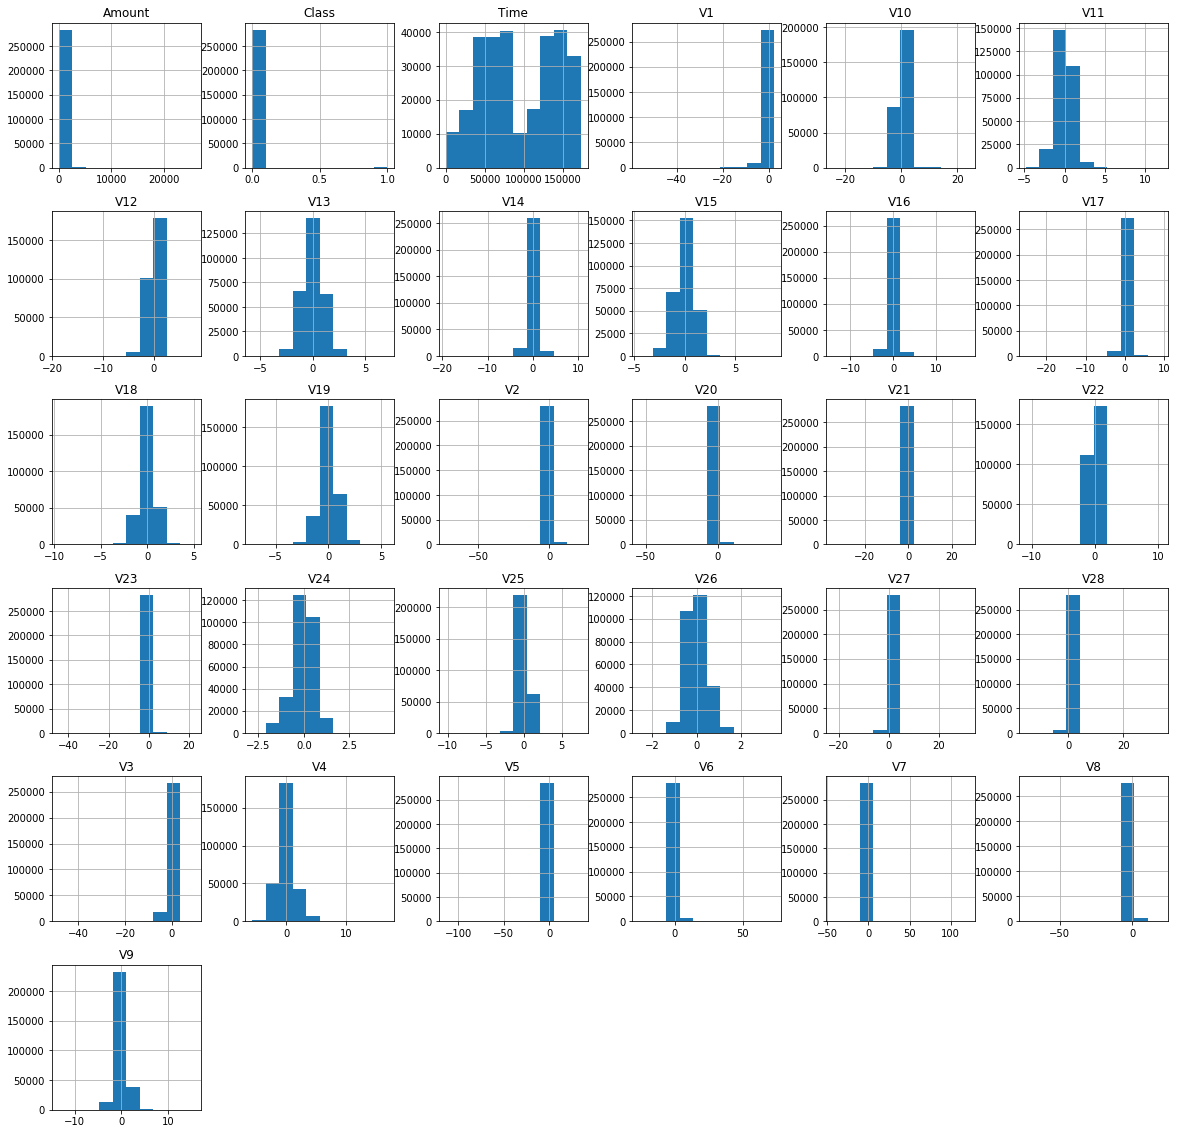

In [7]:
data.hist(figsize = (20,20))
plt.show()

Here, we see that most of the V parameters are clustered around 0 with some fairly large outliers or no outliers. If we look at the class attribute which is the response variable, there are very few fraudulent transactions in comparison valid transactions. It shows that the data is highly imbalanced.

In [8]:
# Determine the number of fraud cases in the dataset
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud) / float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(Fraud)))
print('Valid Cases: {}'.format(len(Valid)))

0.0017304750013189597
Fraud Cases: 492
Valid Cases: 284315


#### Correlation Matrix

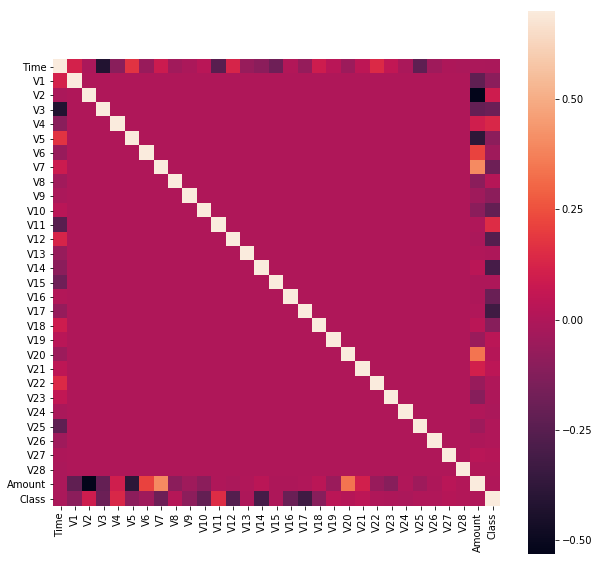

In [12]:
cor_mat = data.corr()
fig = plt.figure(figsize = (10,10))
sns.heatmap(cor_mat, vmax = 0.7, square = True)
plt.show()

In the correlation matrix above, we see that there isn't any strong relationship between the V parameters. We have lots of values close to 0. So, most of them are fairly unrelated. However, we need to see the class, which is our response variable.

We see a lot of variations between class and V parameters. The lighter ones mean positively correlated and the darker ones mean negatively correlated. So, V11 is the strong positive correlation and V17 is the strong negative correlation.

In [3]:
# As Class is our response variable, we assign it to Y and assign predictor variables to X
X = data.iloc[:,0:30]
Y = data.iloc[:,30]

# Print the shapes of X and Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


#### Fit IsolationForest and Local Outlier Factor Model

In [29]:
# define a random state
state = 1

# define the outlier detection method
classifiers = {
    "IsolationForest" : IsolationForest(max_samples = len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    "Local Outlier Factor" : LocalOutlierFactor(n_neighbors = 20,
                                               contamination = outlier_fraction)
}

In [31]:
# Fit the model
no_of_outliers = len(Fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    # Reshape the prediction values to 0 for valid, 1 for fraud
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

IsolationForest: 645
0.997735308472
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.34      0.35      0.35       492

avg / total       1.00      1.00      1.00    284807

Local Outlier Factor: 935
0.996717075072
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.05      0.05      0.05       492

avg / total       1.00      1.00      1.00    284807



Imbalanced classes put “accuracy” out of business. This is a surprisingly a common problem in machine learning (specifically in classification), occurring in datasets with a disproportionate ratio of observations in each class. This is one of the cases. Standard accuracy no longer reliably measures performance, which makes model training much trickier.

In Local Outlier Factor, we see 935 errors, relatively high. And, the accuracy score comes out to be 99.67%. However, if we see the precision, recall and f1-score, they are not as good as we think. For class 0, we have a precision of 100% but for class 1 we have only 0.05, which is not good. Now that means, we have very few actual fraudulent cases that are getting labelled as fraudulent cases. Precision accounts for false positives. 

However, Isolation Forest looks better. Here, we see 645 errors and 99.77% accuracy. Precision is 0.34 which is lot better than local outlier factor.

#### Split the dataset

To evaluate these models, 80% of the dataset is used for training while 20% is set aside for validating and testing.

In [4]:
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#### Fit the RandomForestClassifier directly with the imbalanced data

A random forest model is an ensemble of classification (or regression) trees. Ensembles perform well when individual members are dissimilar, and random forests obtain variation among individual trees using two sources for randomness: first, each tree is built on separate bootstrapped samples of the training data; secondly, only a randomly selected subset of data attributes is considered at each node in building the individual trees. Random forests thus combine the concepts of bagging, where individual models in an ensemble are developed through sampling with replacement from the training data, and the random subspace method, where each tree in an ensemble is built from a random subset of attributes.

In [64]:
# Fit the RandomForest Classifier
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)

y_pred_rf = clf.predict(X_test)

n_errors = (y_pred_rf != y_test).sum()
    
# Run classification metrics
print('{}: {}'.format('Random Forest', n_errors))
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(roc_auc_score(y_test, y_pred_rf))

Random Forest: 30
0.999473333099
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56861
          1       0.93      0.76      0.84       101

avg / total       1.00      1.00      1.00     56962

0.881135358572


If we use the imbalanced data directly in the RandomForestClassifier, we will find the result okay: recall score is 0.76 and the auc = 0.88. Although this result is better than the result from Logistic Regression using imbalanced data directly, shown in next blocks.

#### Fit the RandomForestClassifier with class_weight as balanced

In [63]:
# Fit the RandomForest Classifier
clf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
clf = clf.fit(X_train, y_train)

y_pred_rf = clf.predict(X_test)

n_errors = (y_pred_rf != y_test).sum()
    
# Run classification metrics
print('{}: {}'.format('Random Forest', n_errors))
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(roc_auc_score(y_test, y_pred_rf))

Random Forest: 25
0.999561110916
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56861
          1       0.94      0.80      0.87       101

avg / total       1.00      1.00      1.00     56962

0.900946132143


When the model is trained with RandomForestClassifier with balanced class_weight, we observe only 25 errors. Precision, recall, f1-score and auc are also improved. 80% of the frauds can be detected by this model, which will prevent a lot of loss. 

In [5]:
# Fit the RandomForest Classifier
positive_weight = sum(y_train == 0) / sum(y_train == 1)  # size to repeat y == 1

clf = RandomForestClassifier(random_state=0, class_weight = {0 : 1, 1 : positive_weight}, warm_start = True)

rf_tuned_parameters = {"max_depth": [10, 20, 50], 'n_estimators': [50, 100, 200], 'min_samples_leaf': [10, 20]}

cv_grid = GridSearchCV(clf, param_grid = rf_tuned_parameters, scoring = 'roc_auc', verbose = 5, n_jobs = 70) 

cv_grid.fit(X_train, y_train)

pred_test = cv_grid.predict(X_test)

n_errors = (pred_test != y_test).sum()
    
# Run classification metrics
print('{}: {}'.format('Random Forest', n_errors))
print(accuracy_score(y_test, pred_test))
print(classification_report(y_test, pred_test))
print(roc_auc_score(y_test, pred_test))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=70)]: Done   3 out of  54 | elapsed:  5.2min remaining: 88.6min
[Parallel(n_jobs=70)]: Done  14 out of  54 | elapsed: 29.0min remaining: 82.9min
[Parallel(n_jobs=70)]: Done  25 out of  54 | elapsed: 43.4min remaining: 50.3min
[Parallel(n_jobs=70)]: Done  36 out of  54 | elapsed: 54.6min remaining: 27.3min
[Parallel(n_jobs=70)]: Done  47 out of  54 | elapsed: 64.9min remaining:  9.7min
[Parallel(n_jobs=70)]: Done  54 out of  54 | elapsed: 67.4min finished


Random Forest: 35
0.999385555282
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56861
          1       0.82      0.84      0.83       101

avg / total       1.00      1.00      1.00     56962

0.920625005115


In [7]:
print("\n Confustion matrix on test data: \n" + str(confusion_matrix(y_test, pred_test)))


 Confustion matrix on test data: 
[[56842    19]
 [   16    85]]


Compared with balanced class_weight, though the no. of errors increaed from 25 to 35, the recall score increased from 0.80 to 0.84 and the precision decreases from 0.94 to 0.82. The auc is 0.92 that indicates improvement in model. The closer the AUC score to 1, the better is the model. 

Overall, I think this model works well: 84% of the frauds can be detected by this model, which will prevent a lot of loss. At the same time, only 0.03% of the non-frauds will be mistakenly predicted as frauds. This will result in very little potential loss for the company. The company can also do manual review of these false fraud detections.

#### Logistic Regression Classifier

Qualitative response models are appropriate when dependent variable is categorical. In this study, our dependent variable fraud
is binary, and logistic regression is a widely used technique in such problems. Binary choice models have been used in studying
fraud. For example, used binary choice models in the case of insurance frauds to predict the likelihood of a claim being fraudulent. In case of insurance fraud, investigators use the estimated probabilities to flag individuals that are more likely to submit a fraudulent claim.

In [8]:
# Fit the logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)

n_errors = (y_pred_lr != y_test).sum()

# Run classification metrics
print('{}: {}'.format('Logistic Regression', n_errors))
print(accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print(roc_auc_score(y_test, y_pred_lr))
print("\n Confustion matrix on test data: \n" + str(confusion_matrix(y_test, y_pred_lr)))

Logistic Regression: 64
0.998876443945
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56861
          1       0.74      0.56      0.64       101

avg / total       1.00      1.00      1.00     56962

0.782002350356

 Confustion matrix on test data: 
[[56841    20]
 [   44    57]]


Logistic Regression gives less number of misclassifications, however, recall and auc are very low.

#### Naive Bayes Classifier

Naive Bayes a statistical approach based on Bayesian theory, which chooses the decision based on highest probability. Bayesian probability estimates unknown probabilities from known values. It also allows prior knowledge and logic to be applied to uncertain statements. This technique has an assumption of conditional independence among features in the data.

In [68]:
# Fit the Naive Bayes model
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_nb = clf.predict(X_test)

n_errors = (y_pred_nb != y_test).sum()

# Run classification metrics
print('{}: {}'.format('Naive Bayes', n_errors))
print(accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print(roc_auc_score(y_test, y_pred_nb))

Naive Bayes: 421
0.992609107826
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     56861
          1       0.14      0.61      0.23       101

avg / total       1.00      0.99      0.99     56962

0.803571624463


Naive Bayes Classifier performs very bad in this case.

#### Box plots and Outlier Detection

In statistics, an outlier is an observation point that is distant from other observations. In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.

Percentiles and Quartiles are very useful when we need to identify the outliers in the data. They also help us understand the basic distribution of the data.

Box plot uses the IQR method to display data and outliers(shape of the data). The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

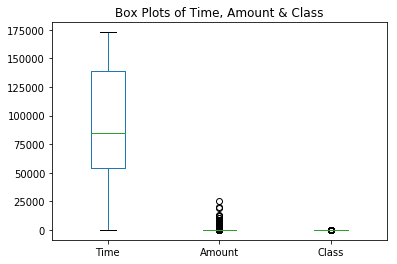

In [63]:
data.boxplot(column = ['Time','Amount','Class'], grid = False)
plt.title('Box Plots of Time, Amount & Class')
plt.show()

Sometimes the outliers are so evident that, the box appear to be a horizontal line in box plot.

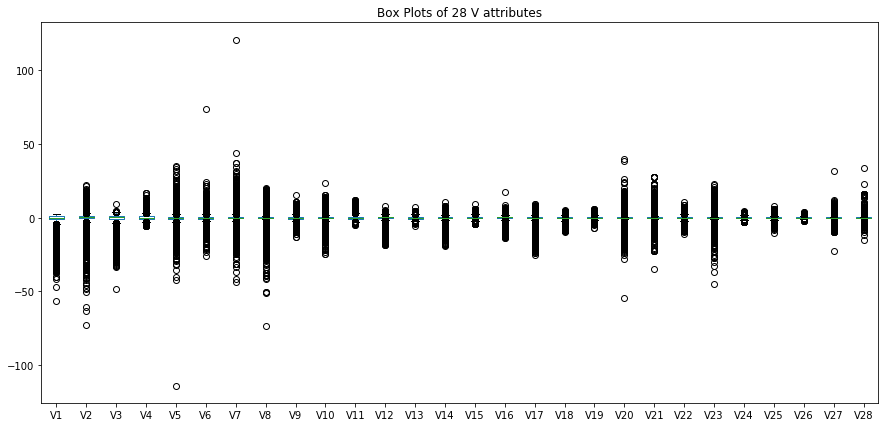

In [66]:
data.boxplot(column = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
                       'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
                       'V21','V22','V23','V24','V25','V26','V27','V28'], grid = False, figsize = (15,7))
plt.title('Box Plots of 28 V attributes')
plt.show()

So, some parameters have large no. of outliers and some do not have.

#### Calculate IQR

In [28]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

#### Remove the outliers

In [30]:
data_without_outlier = data.iloc[:,0:30][~((data.iloc[:,0:30] < (Q1 - 1.5 * IQR)) | (data.iloc[:,0:30] > (Q3 + 1.5 * IQR))).any(axis=1)]
data_without_outlier.shape

(146334, 30)

In [45]:
l = list(data_without_outlier.index)

In [46]:
data_without_outlier['Class'] = [data['Class'].loc[i] for i in l]

In [49]:
Fraud = data_without_outlier[data_without_outlier['Class'] == 1]
Valid = data_without_outlier[data_without_outlier['Class'] == 0]

print('Fraud Cases: {}'.format(len(Fraud)))
print('Valid Cases: {}'.format(len(Valid)))

Fraud Cases: 15
Valid Cases: 146319


After removing outliers, we are left with 15 fraud cases out of 492 i.e 97% of fraud cases are removed. And 49% of valid cases are removed. This is making our data more imbalanced. 

#### Boxplots after removing outliers

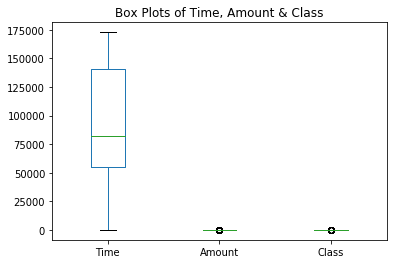

In [50]:
data_without_outlier.boxplot(column = ['Time','Amount','Class'], grid = False)
plt.title('Box Plots of Time, Amount & Class')
plt.show()

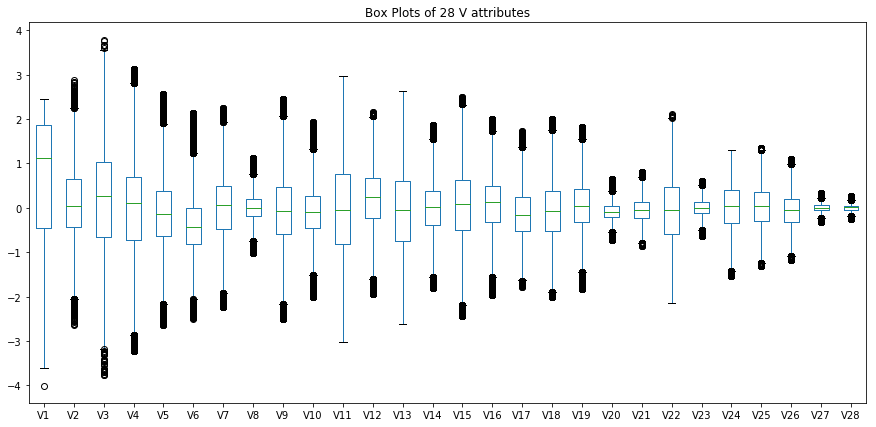

In [51]:
data_without_outlier.boxplot(column = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10',
                       'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
                       'V21','V22','V23','V24','V25','V26','V27','V28'], grid = False, figsize = (15,7))
plt.title('Box Plots of 28 V attributes')
plt.show()

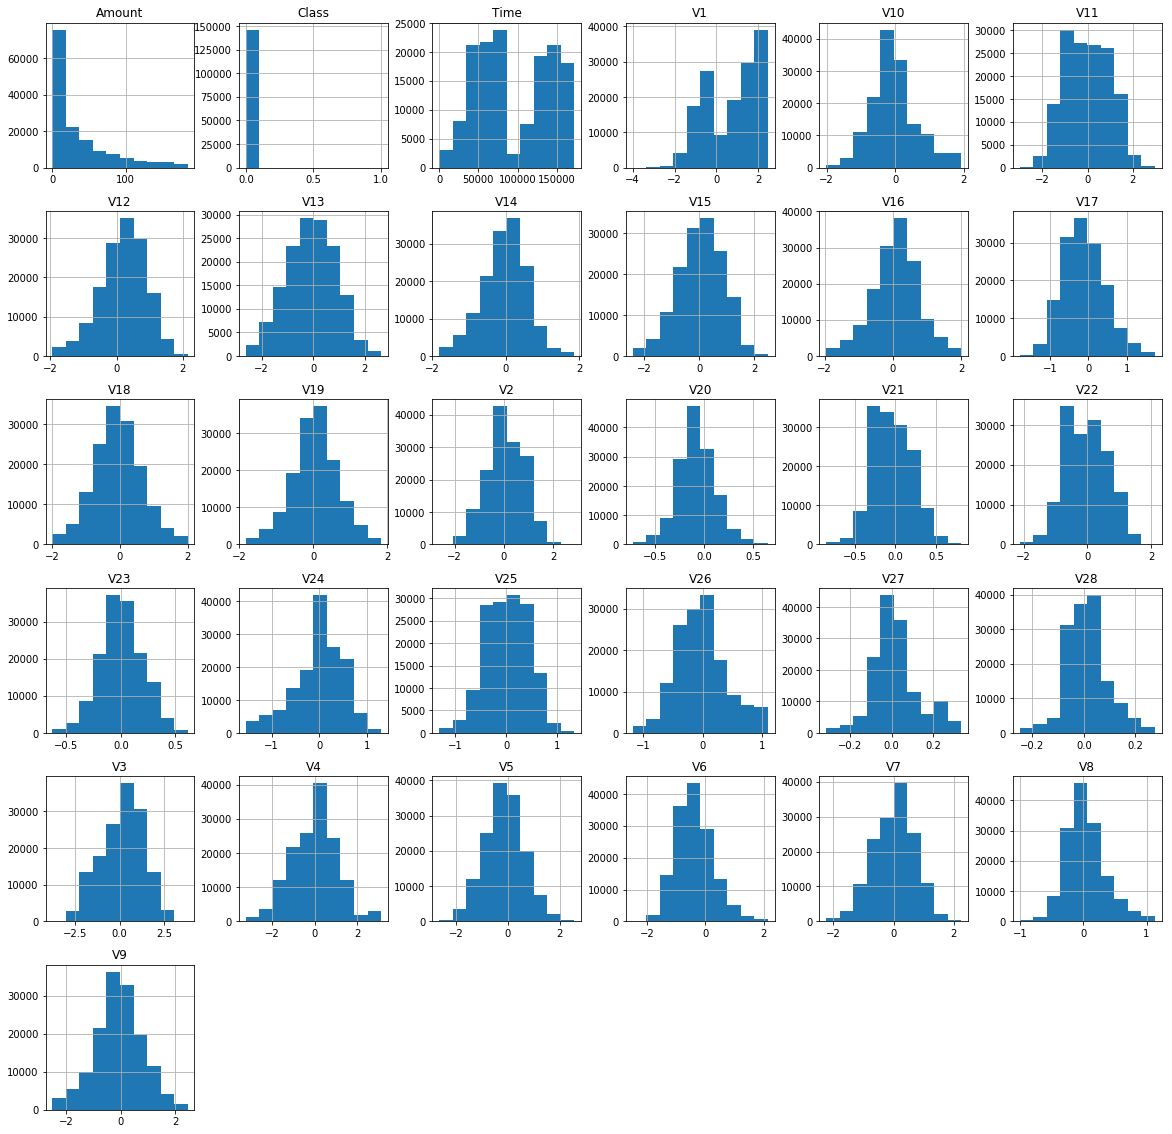

In [52]:
data_without_outlier.hist(figsize = (20,20))
plt.show()

Though our data is normalized after removing outliers, however, it will be an imprudent decision if we consider the class distribution. We won't get accurate and intuitive results. 

Detection of credit card fraud using isolation forest, local outlier factor, random forest, naive bayes and logistic regression techniques is investigated and the results show that the proposed classifiers of random forest approaches outperform other approaches in solving the problem. 